In [1]:
from sklearn import metrics

def clustring_eval(x, y):
    """
    :param x: clustering predicted vector
    :param y: clustering true vectors
    """
    return {
        'rand': metrics.rand_score(y, x),
        'adjusted_rand': metrics.adjusted_rand_score(y, x),
        'adjusted_mutual_info': metrics.adjusted_mutual_info_score(y, x),
        'homogeneity': metrics.homogeneity_score(y, x),
        'completeness': metrics.completeness_score(y, x),
        'v_measure': metrics.v_measure_score(y, x),
        'fowlkes_mallows': metrics.fowlkes_mallows_score(y, x),
        # other measures, like https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient can not be used
        #   becuase we don't know the feaure vecotrs.
    }

# Binary Fair Clustering - Binary Adjacency Matrix

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

def show_graph_with_colors(A, colors=[], labels=[], seed=0):
    rows, cols = np.where(A == 1)
    edges = zip(rows.tolist(), cols.tolist())

    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=seed)  # positions for all nodes
    for color in set(colors):
        nx.draw_networkx_nodes(G,
                              pos,
                              nodelist=[i for i, c in enumerate(colors) if c==color],
                              node_color=color)
        nx.draw_networkx_nodes(G,
                              pos,
                              nodelist=[i for i, c in enumerate(colors) if c==color],
                              node_color=color)

    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    labels = {i: label for i, label in enumerate(labels)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, alpha=0.5)
    return plt

In [3]:
import numpy as np

np.random.seed(0)
N1 = 20 # size of 1st cluster
N2 = 20 # size of 2nd cluster
N = N1 + N2
p_inter = 0.05 # inter-cluster connection probablity
p_intera = 0.90 # intera-cluster connection probability

def get_random_sym_nonloop_adj(n, p):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            is_connected = int((np.random.rand() < p) * 1)
            A[i, j] = is_connected
            A[j, i] = is_connected
    return A


def get_sparse_matrix(p, size):
    """
    :param p: inter-cluster connection probablity
    """
    return np.random.binomial(
        1,
        [[p for i in range(size[1])] for j in range(size[0])],
        size=size)

In [4]:
s = np.random.choice([-1, 1], size=(N,)) # specificity vector
colors = ['tab:red' if x == 1 else 'tab:blue' for x in s]
s

array([-1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
        1,  1, -1,  1,  1, -1])

In [5]:
A0 = get_random_sym_nonloop_adj(N1, p_intera)
A1 = get_sparse_matrix(p_inter, size=(N1, N2))
A2 = get_random_sym_nonloop_adj(N2, p_intera)

A = np.block([
    [A0, A1],
    [A1.T, A2]
    ])
A

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

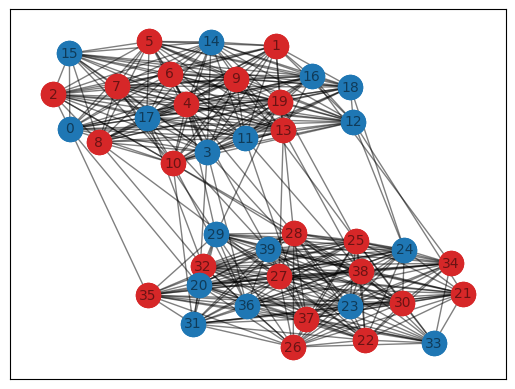

In [6]:
show_graph_with_colors(A, colors=colors, labels=range(len(colors)))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

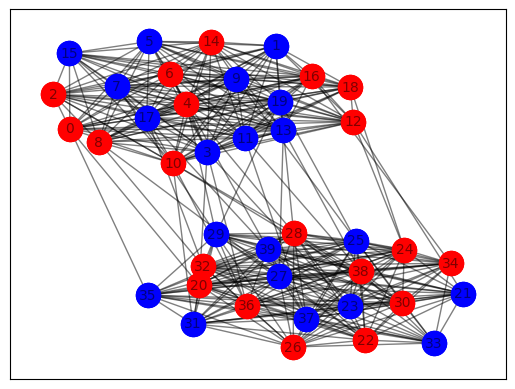

In [7]:
show_graph_with_colors(A,
                       labels=range(len(s)),
                       colors=['r' if i % 2 == 0 else 'b' for i, label in enumerate(s)])

## Simple Clustring

The problem of simple clustering translated into below equation:
$$
\max_x x^T A x \\
s.t ~ x \in \{-1, 1\}^n; ~~ x^T1 = 0
$$

After a relaxation it would be rewritten as:
$$
\max_x Tr(AX) \\
s.t ~ x \in \{-1, 1\}^n ; ~~ ||X||_* = ||xx^T||_* \leq 1, ~ x^T1 = 0
$$

which is equal to:
$$
\max_x Tr((A - \mu 11^T)X) \\
s.t ~ x \in \{-1, 1\}^n ; ~~ ||X||_* = ||xx^T||_* \leq 1
$$

### Solution: EVD
Basd on [stackexchange](https://math.stackexchange.com/questions/683959/singular-values-of-matrix-as-optimization-problem).

First eigen-vector should be removed. Select the second one.

In [8]:
mu = 1
ONE_ONET = np.ones((N, N))

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(A - mu * ONE_ONET)
eigenvalues

array([-21.405965  ,  15.90797268,  -4.13649894,   2.23606093,
        -3.76301978,  -3.49929682,   1.88909807,  -3.30870248,
         1.67725896,   1.58110118,  -3.10284723,  -2.92651772,
        -2.86803103,   1.33809202,  -2.60469716,  -2.47400476,
         1.19239403,   1.01643524,  -2.22839122,  -2.1524111 ,
         0.77075421,   0.6022711 ,  -1.89623851,   0.32402394,
        -1.77716811,   0.13494803,   0.02456039,  -0.04040277,
        -0.15182542,  -0.29870394,  -1.54429761,  -1.4328251 ,
        -1.26689539,  -1.19123362,  -1.068042  ,  -1.00615531,
        -0.53726622,  -0.72063382,  -0.6184865 ,  -0.67441322])

In [10]:
(eigenvalues[0] * eigenvectors.T[0])

array([3.49136259, 3.68218529, 3.50974754, 2.98272796, 3.1912929 ,
       3.47730297, 3.32282108, 3.16814205, 3.52033771, 3.350461  ,
       3.13499231, 3.18566455, 3.35103493, 3.0364337 , 3.49618693,
       3.8244511 , 3.32463957, 3.0143437 , 3.64678553, 3.50464026,
       3.48765375, 3.6423911 , 3.48002022, 3.31866096, 3.14402665,
       2.95798079, 3.44839883, 3.16564038, 3.17437005, 3.17373472,
       3.31119921, 3.68349837, 3.15978634, 3.93916454, 3.4899993 ,
       3.79761714, 3.65561365, 3.47247667, 3.16814564, 3.15235215])

In [11]:
(A - mu * ONE_ONET) @ eigenvectors.T[0]

array([3.49136259, 3.68218529, 3.50974754, 2.98272796, 3.1912929 ,
       3.47730297, 3.32282108, 3.16814205, 3.52033771, 3.350461  ,
       3.13499231, 3.18566455, 3.35103493, 3.0364337 , 3.49618693,
       3.8244511 , 3.32463957, 3.0143437 , 3.64678553, 3.50464026,
       3.48765375, 3.6423911 , 3.48002022, 3.31866096, 3.14402665,
       2.95798079, 3.44839883, 3.16564038, 3.17437005, 3.17373472,
       3.31119921, 3.68349837, 3.15978634, 3.93916454, 3.4899993 ,
       3.79761714, 3.65561365, 3.47247667, 3.16814564, 3.15235215])

In [12]:
eigenvectors.T[1]

array([-0.14262062, -0.16801439, -0.1586836 , -0.15119469, -0.16025755,
       -0.17759509, -0.16832422, -0.17747344, -0.13895091, -0.16749341,
       -0.13830489, -0.15736613, -0.14974375, -0.14950378, -0.17755688,
       -0.15767434, -0.166974  , -0.1670025 , -0.14857431, -0.14020036,
        0.14123941,  0.15204686,  0.17874773,  0.16980597,  0.1605424 ,
        0.16890346,  0.17783074,  0.16112575,  0.14251151,  0.14036173,
        0.17056832,  0.15269843,  0.16065252,  0.1507443 ,  0.15920238,
        0.14124708,  0.13343635,  0.16160096,  0.16106027,  0.15675158])

In [13]:
def cluster_using_EVD(M):
    """
    :param M: in-trace matrix
    """
    eigenvalues, eigenvectors = np.linalg.eig(M)
    # Changed to 1, 0 was trivial answer
    return (eigenvectors.T[1] > 0) * 2 - 1

def defualt_clustring_EVD(A, mu=1):
    """
    :param A: Adjacency matrix
    """
    return cluster_using_EVD(A - mu * ONE_ONET)

{'adjusted_mutual_info': 1.0,
 'adjusted_rand': 1.0,
 'completeness': 1.0,
 'fowlkes_mallows': 1.0,
 'homogeneity': 1.0,
 'rand': 1.0,
 'v_measure': 1.0}


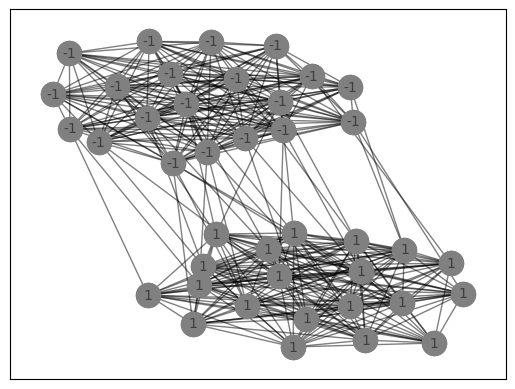

In [14]:
x = defualt_clustring_EVD(A, mu=1)
show_graph_with_colors(A, labels=x, colors=['gray' for _ in x])
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))

## Fair Clustring (1st approach)

The problem of simple clustering translated into below equation:
$$
\max_x x^T A x \\
s.t ~ x \in \{-1, 1\}^n; ~~ x^T1 = 0,~x^Ts = 0
$$

which is equal to:
$$
\max_x x^T (A - λ s s^T) x\\
s.t ~ x \in \{-1, 1\}^n; ~~ x^T1 = 0
$$

which is also equal to:
$$
\max_x x^T (A - λ s s^T - \mu 1 1^T) x\\
s.t ~ x \in \{-1, 1\}^n
$$

Which is simply solvable by substituting $A$ to $A - λ s s^T$ from the simple clustring model.

### Solution: EVD

In [15]:
def fair_clustering_EVD(A, s, mu=1, lambda_=1):
    return defualt_clustring_EVD(A - lambda_ * s.reshape((N, 1)) @ s.reshape((N, 1)).T, mu=mu)

Temporal clustering:
{'adjusted_mutual_info': 1.0,
 'adjusted_rand': 1.0,
 'completeness': 1.0,
 'fowlkes_mallows': 1.0,
 'homogeneity': 1.0,
 'rand': 1.0,
 'v_measure': 1.0}
Specifity clustering:
{'adjusted_mutual_info': -0.01738955730844305,
 'adjusted_rand': -0.023144190939575253,
 'completeness': 0.0018457384019467378,
 'fowlkes_mallows': 0.48117729838110324,
 'homogeneity': 0.0018763066979074034,
 'rand': 0.48846153846153845,
 'v_measure': 0.0018608970247530239}


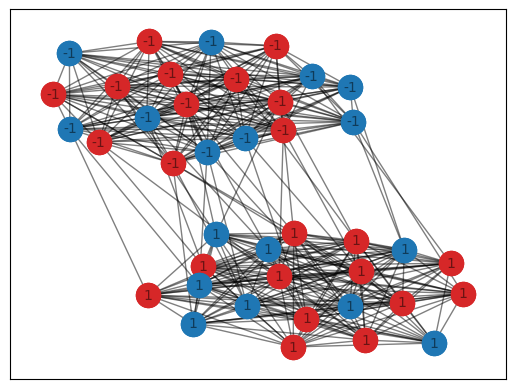

In [16]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=0)
show_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))

Temporal clustering:
{'adjusted_mutual_info': -0.017389557308443163,
 'adjusted_rand': -0.023144190939575253,
 'completeness': 0.0018763066979074034,
 'fowlkes_mallows': 0.48117729838110324,
 'homogeneity': 0.0018457384019467378,
 'rand': 0.48846153846153845,
 'v_measure': 0.0018608970247530239}
Specifity clustering:
{'adjusted_mutual_info': 1.0,
 'adjusted_rand': 1.0,
 'completeness': 1.0,
 'fowlkes_mallows': 1.0,
 'homogeneity': 1.0,
 'rand': 1.0,
 'v_measure': 1.0}


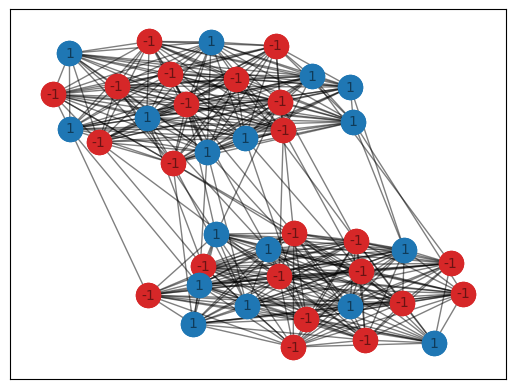

In [17]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=-0.5)
show_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))

Temporal clustering:
{'adjusted_mutual_info': 0.14073039891224878,
 'adjusted_rand': 0.1819975014793872,
 'completeness': 0.15828899014890538,
 'fowlkes_mallows': 0.5852156331662067,
 'homogeneity': 0.15571018749175822,
 'rand': 0.591025641025641,
 'v_measure': 0.1569889992652978}
Specifity clustering:
{'adjusted_mutual_info': 0.32954398867914325,
 'adjusted_rand': 0.3435854279120836,
 'completeness': 0.3423530679929779,
 'fowlkes_mallows': 0.6709511568123393,
 'homogeneity': 0.3423530679929779,
 'rand': 0.6717948717948717,
 'v_measure': 0.3423530679929779}


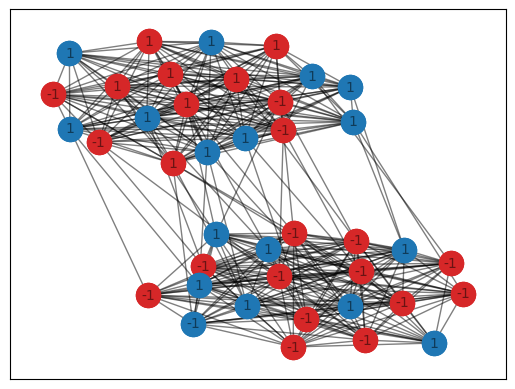

In [18]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=-0.41)
show_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))

## Analysis

From now on we will use SVD.

In [19]:
s

array([-1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
        1,  1, -1,  1,  1, -1])

In [20]:
x

array([ 1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,
       -1, -1,  1, -1, -1,  1])

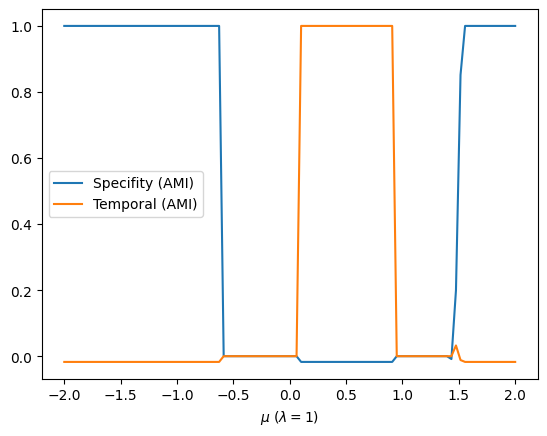

In [21]:
MUs = np.linspace(-2, 2, 100)
SPECs = []
TEMPs = []
for mu in MUs:
    x = fair_clustering_EVD(A, s, mu=mu, lambda_=1)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(MUs, SPECs)
plt.plot(MUs, TEMPs)
plt.xlabel("$\mu$ ($\lambda=1$)")
plt.legend(["Specifity (AMI)", "Temporal (AMI)"]) # AMI: adjusted mutual information

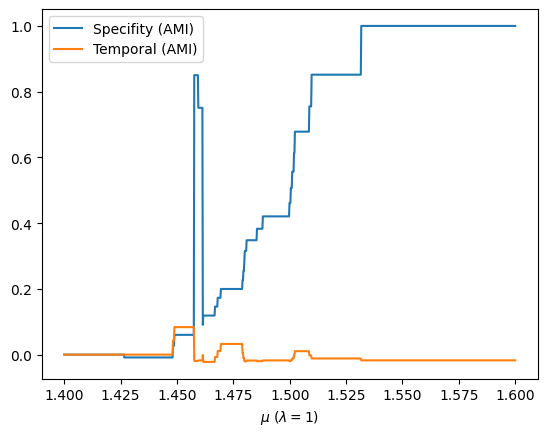

In [22]:
MUs = np.linspace(1.4, 1.6, 1000)
SPECs = []
TEMPs = []
for mu in MUs:
    x = fair_clustering_EVD(A, s, mu=mu, lambda_=1)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(MUs, SPECs)
plt.plot(MUs, TEMPs)
plt.xlabel("$\mu$ ($\lambda=1$)")
plt.legend(["Specifity (AMI)", "Temporal (AMI)"]) # AMI: adjusted mutual information

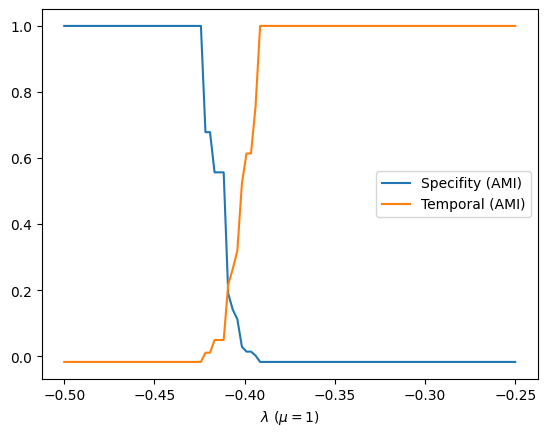

In [24]:
LAMBDAs = np.linspace(-0.5, -0.25, 100)
SPECs = []
TEMPs = []
for lambda_ in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=1, lambda_=lambda_)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=1$)")
plt.legend(["Specifity (AMI)", "Temporal (AMI)"]) # AMI: adjusted mutual information

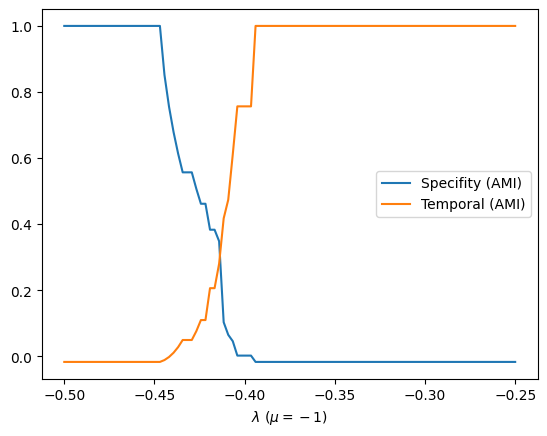

In [27]:
LAMBDAs = np.linspace(-0.5, -0.25, 100)
SPECs = []
TEMPs = []
for lambda_ in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=-1, lambda_=lambda_)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=-1$)")
plt.legend(["Specifity (AMI)", "Temporal (AMI)"]) # AMI: adjusted mutual information

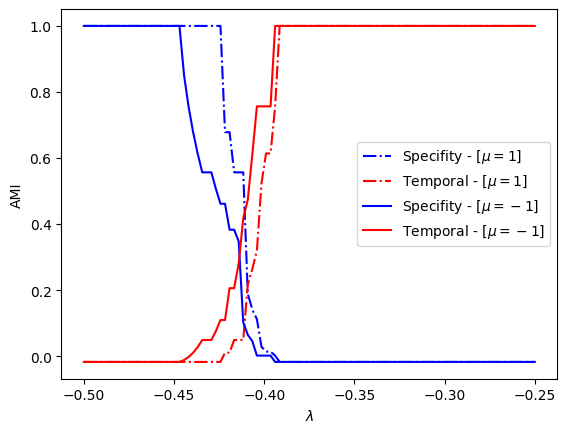

In [32]:
LAMBDAs = np.linspace(-0.5, -0.25, 100)
SPECs_mu1 = []
TEMPs_mu1 = []
SPECs_mu_1 = []
TEMPs_mu_1 = []
for lambda_ in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=1, lambda_=lambda_)
    TEMPs_mu1.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs_mu1.append(clustring_eval(x, s)['adjusted_mutual_info'])

    x = fair_clustering_EVD(A, s, mu=-1, lambda_=lambda_)
    TEMPs_mu_1.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs_mu_1.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs_mu1, 'b-.')
plt.plot(LAMBDAs, TEMPs_mu1, 'r-.')
plt.plot(LAMBDAs, SPECs_mu_1, 'b')
plt.plot(LAMBDAs, TEMPs_mu_1, 'r')
plt.xlabel("$\lambda$")
plt.ylabel("AMI")
plt.legend(["Specifity - [$\mu=1$]", "Temporal - [$\mu=1$]",
            "Specifity - [$\mu=-1$]", "Temporal - [$\mu=-1$]"]) # AMI: adjusted mutual information

# Binary Fair Clustering - Weighted Matrix

In [33]:
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

def show_weighted_graph_with_colors(A, colors=[], labels=[], seed=0):
    G = nx.Graph()
    n, m = A.shape
    for i in range(n):
        for j in range(i + 1, m):
            w = A[i, j]
            if w > 0:
                G.add_edge(i, j, weight=w, len=100/w)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    labels = {i: label for i, label in enumerate(labels)}

    pos = nx.spring_layout(G, seed=seed)
    fig, ax = plt.subplots()

    nx.draw(G, pos, width=weights, ax=ax)
    for color in set(colors):
        nx.draw_networkx_nodes(G,
                              pos,
                              ax=ax,
                              nodelist=[i for i, c in enumerate(colors) if c==color],
                              node_color=color)
    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=10)
    return plt

In [34]:
import numpy as np

np.random.seed(0)
N1 = 20 # size of 1st cluster
N2 = 10 # size of 2nd cluster
N = N1 + N2
lambda_ = 1
ONE_ONET = np.ones((N, N))
p_inter_range = (0, 0.5) # inter-cluster connection probablity
p_intera_range = (0.5, 1.0) # intera-cluster connection probability

def get_random_sym_nonloop_adj_p_range(n, p):
    A = []
    for i in range(n):
        A.append([*[0]*i, *np.random.uniform(*p, (n-i,))])
    A = np.array(A)

    for i in range(n):
        for j in range(i+1, n):
            A[j, i] = A[i, j]
    return A

def get_random_inter_cluster(n, m, p):
    return np.random.uniform(*p, (n, m))

In [35]:
s = np.random.choice([-1, 1], size=(N,)) # specificity vector
colors = ['tab:red' if x == 1 else 'tab:blue' for x in s]
s

array([-1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1])

In [36]:
A0 = get_random_sym_nonloop_adj_p_range(N1, p_intera_range)
A1 = get_random_inter_cluster(N1, N2, p_inter_range)
A2 = get_random_sym_nonloop_adj_p_range(N2, p_intera_range)

A = np.block([
    [A0, A1],
    [A1.T, A2]
    ])
A

array([[0.54356465, 0.5101092 , 0.91630992, 0.88907838, 0.93500607,
        0.98930917, 0.89957928, 0.73073968, 0.89026459, 0.55913721,
        0.81996051, 0.57167664, 0.97233446, 0.76092416, 0.70733097,
        0.63227781, 0.88711684, 0.72807517, 0.78421697, 0.5093949 ,
        0.47639583, 0.34374414, 0.10775384, 0.4736853 , 0.3654279 ,
        0.12697082, 0.10665599, 0.25910036, 0.01283136, 0.10373504],
       [0.5101092 , 0.80881775, 0.80604786, 0.808467  , 0.97187404,
        0.84091015, 0.67975395, 0.71851598, 0.8488156 , 0.53011274,
        0.83338336, 0.83531893, 0.60519128, 0.56446315, 0.65771418,
        0.68185539, 0.78509839, 0.71930076, 0.99418692, 0.55102241,
        0.21234273, 0.18708499, 0.23178771, 0.13881435, 0.29339217,
        0.4319278 , 0.05876593, 0.25868955, 0.06603405, 0.35842984],
       [0.91630992, 0.80604786, 0.60443838, 0.58065476, 0.82655416,
        0.6266458 , 0.73315539, 0.6222128 , 0.57948479, 0.55518757,
        0.82816479, 0.56909148, 0.59829118, 0.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

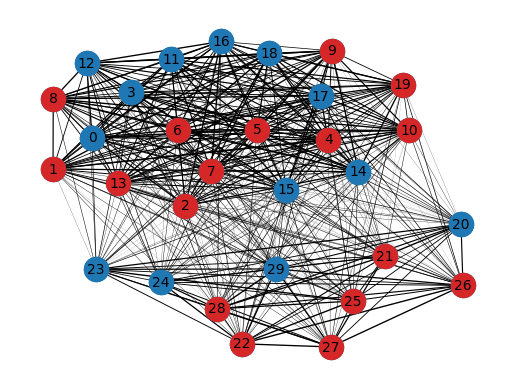

In [37]:
show_weighted_graph_with_colors(A, colors=colors, labels=range(len(colors)))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

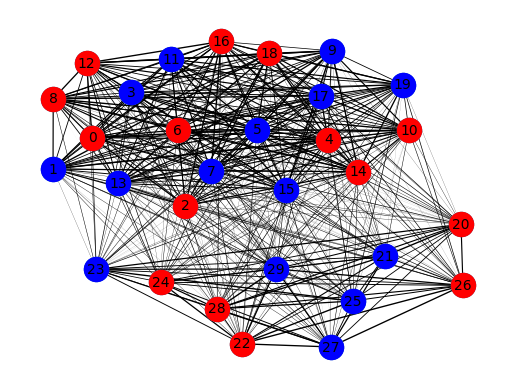

In [38]:
show_weighted_graph_with_colors(A,
                       labels=range(len(s)),
                       colors=['r' if i % 2 == 0 else 'b' for i, label in enumerate(s)])

Temporal clustering:
{'adjusted_mutual_info': 1.0,
 'adjusted_rand': 1.0,
 'completeness': 1.0,
 'fowlkes_mallows': 1.0,
 'homogeneity': 1.0,
 'rand': 1.0,
 'v_measure': 1.0}
Specifity clustering:
{'adjusted_mutual_info': -0.025909246073267268,
 'adjusted_rand': -0.033145088932284794,
 'completeness': 0.0017836738096980774,
 'fowlkes_mallows': 0.49943296540754345,
 'homogeneity': 0.0016592822919774953,
 'rand': 0.4827586206896552,
 'v_measure': 0.0017192309629830646}


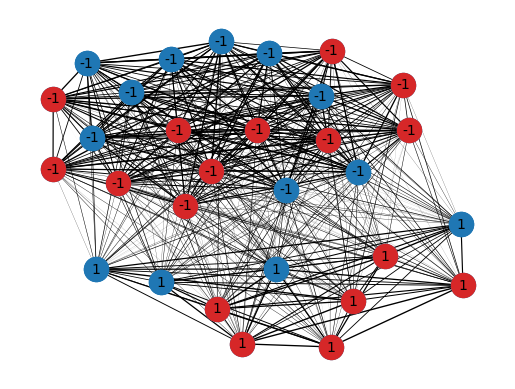

In [61]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=0)
show_weighted_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))
plt.savefig(f"graph_lamb0.pdf", bbox_inches='tight')

Temporal clustering:
{'adjusted_mutual_info': -0.02590924607326723,
 'adjusted_rand': -0.033145088932284794,
 'completeness': 0.0016592822919774953,
 'fowlkes_mallows': 0.49943296540754345,
 'homogeneity': 0.0017836738096980774,
 'rand': 0.4827586206896552,
 'v_measure': 0.0017192309629830646}
Specifity clustering:
{'adjusted_mutual_info': 1.0,
 'adjusted_rand': 1.0,
 'completeness': 1.0,
 'fowlkes_mallows': 1.0,
 'homogeneity': 1.0,
 'rand': 1.0,
 'v_measure': 1.0}


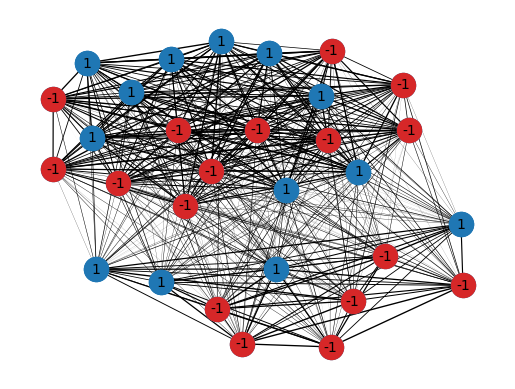

In [62]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=-0.4)
show_weighted_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))
plt.savefig(f"graph_lamb04.pdf", bbox_inches='tight')

Temporal clustering:
{'adjusted_mutual_info': 0.24695221607765275,
 'adjusted_rand': 0.26181818181818184,
 'completeness': 0.2561408693164448,
 'fowlkes_mallows': 0.639211773981008,
 'homogeneity': 0.27893066680431655,
 'rand': 0.6298850574712643,
 'v_measure': 0.2670504358809644}
Specifity clustering:
{'adjusted_mutual_info': 0.14631436690770344,
 'adjusted_rand': 0.19035532994923857,
 'completeness': 0.16702580990126062,
 'fowlkes_mallows': 0.5849316903126366,
 'homogeneity': 0.16920212582026664,
 'rand': 0.5954022988505747,
 'v_measure': 0.168106924497503}


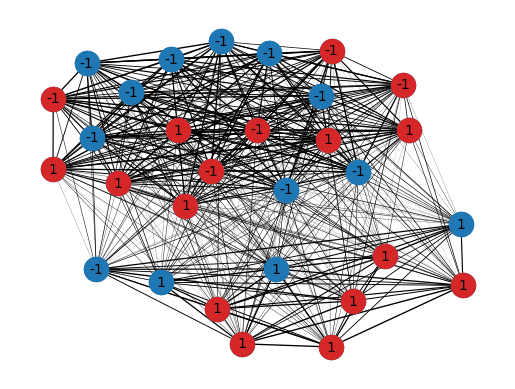

In [63]:
x = fair_clustering_EVD(A, s, mu=1, lambda_=-0.24)
show_weighted_graph_with_colors(A, labels=x, colors=colors)
print("Temporal clustering:")
pprint(clustring_eval(x, [*[1]*N1, *[-1]*N2]))
print("="*20)
print("Specifity clustering:")
pprint(clustring_eval(x, s))
plt.savefig(f"graph_lamb_024.pdf", bbox_inches='tight')

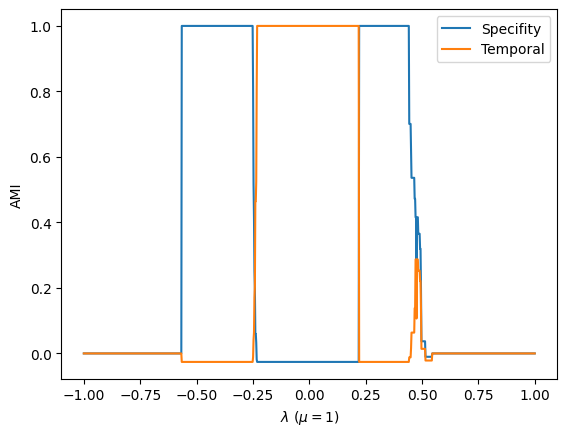

In [77]:
LAMBDAs = np.linspace(-1, 1, 1000)
SPECs = []
TEMPs = []
for LAMBDA in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=1, lambda_=LAMBDA)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=1$)")
plt.ylabel("AMI")
plt.legend(["Specifity", "Temporal"]) # AMI: adjusted mutual information
plt.savefig(f"change_lambda__1_1_mu1.pdf", bbox_inches='tight')

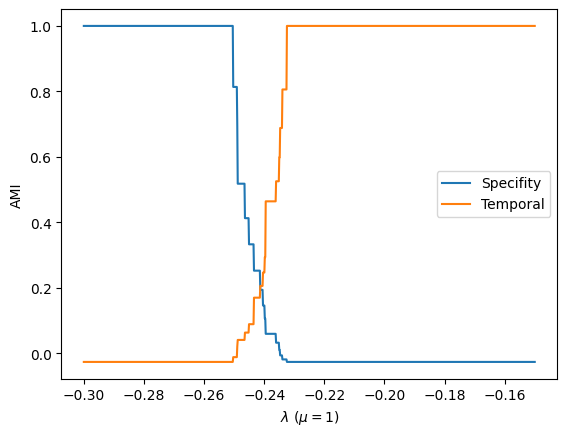

In [78]:
LAMBDAs = np.linspace(-0.3, -0.15, 1000)
SPECs = []
TEMPs = []
for LAMBDA in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=1, lambda_=LAMBDA)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=1$)")
plt.ylabel("AMI")
plt.legend(["Specifity", "Temporal"]) # AMI: adjusted mutual information
plt.savefig(f"change_lambda__03_015_mu1.pdf", bbox_inches='tight')

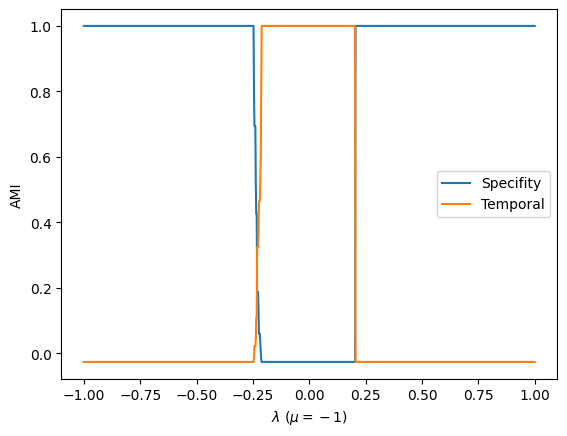

In [79]:
LAMBDAs = np.linspace(-1, 1, 1000)
SPECs = []
TEMPs = []
for LAMBDA in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=-1, lambda_=LAMBDA)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=-1$)")
plt.ylabel("AMI")
plt.legend(["Specifity", "Temporal"]) # AMI: adjusted mutual information
plt.savefig(f"change_lambda__1_1_mu_1.pdf", bbox_inches='tight')

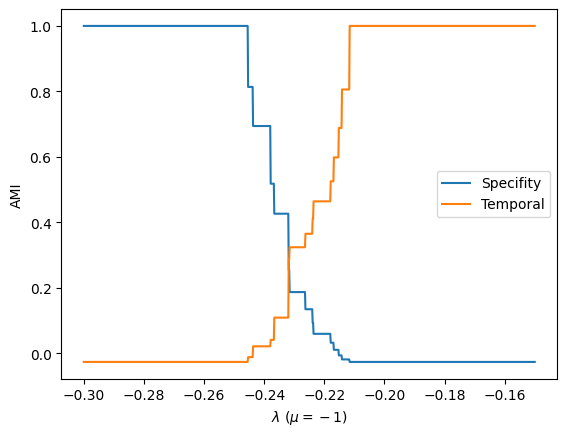

In [80]:
LAMBDAs = np.linspace(-0.3, -0.15, 1000)
SPECs = []
TEMPs = []
for LAMBDA in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=-1, lambda_=LAMBDA)
    TEMPs.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs)
plt.plot(LAMBDAs, TEMPs)
plt.xlabel("$\lambda$ ($\mu=-1$)")
plt.ylabel("AMI")
plt.legend(["Specifity", "Temporal"]) # AMI: adjusted mutual information
plt.savefig(f"change_lambda__03_015_mu_1.pdf", bbox_inches='tight')

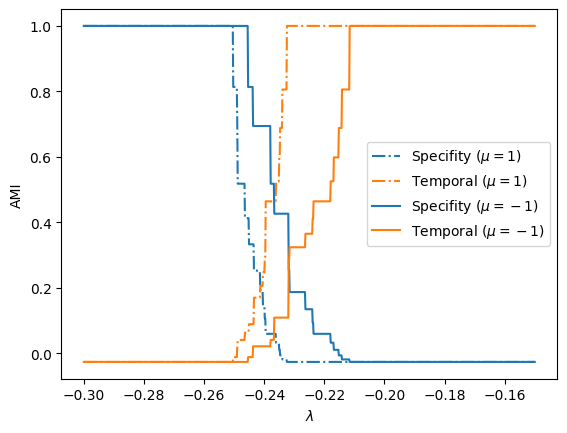

In [81]:
LAMBDAs = np.linspace(-0.3, -0.15, 1000)
SPECs_mu1 = []
TEMPs_mu1 = []
SPECs_mu_1 = []
TEMPs_mu_1 = []
for lambda_ in LAMBDAs:
    x = fair_clustering_EVD(A, s, mu=1, lambda_=lambda_)
    TEMPs_mu1.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs_mu1.append(clustring_eval(x, s)['adjusted_mutual_info'])

    x = fair_clustering_EVD(A, s, mu=-1, lambda_=lambda_)
    TEMPs_mu_1.append(clustring_eval(x, [*[1]*N1, *[-1]*N2])['adjusted_mutual_info'])
    SPECs_mu_1.append(clustring_eval(x, s)['adjusted_mutual_info'])

plt.plot(LAMBDAs, SPECs_mu1, 'C0-.')
plt.plot(LAMBDAs, TEMPs_mu1, 'C1-.')
plt.plot(LAMBDAs, SPECs_mu_1, 'C0')
plt.plot(LAMBDAs, TEMPs_mu_1, 'C1')
plt.xlabel("$\lambda$")
plt.ylabel("AMI")
plt.legend(["Specifity ($\mu=1$)", "Temporal ($\mu=1$)",
            "Specifity ($\mu=-1$)", "Temporal ($\mu=-1$)"]) # AMI: adjusted mutual information

plt.savefig(f"change_lambda__03__015_mu_1VSmu1.pdf", bbox_inches='tight')

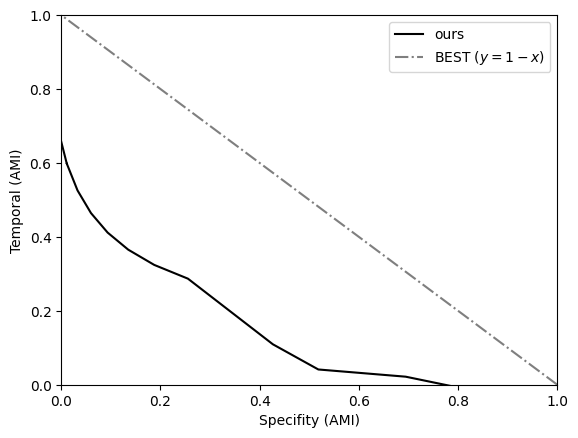

In [84]:
plt.plot(SPECs, TEMPs, 'black')
plt.plot(SPECs, 1 - np.array(SPECs), 'tab:gray', linestyle='-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Specifity (AMI)")
plt.ylabel("Temporal (AMI)")
plt.legend(["ours", "BEST ($y=1-x$)"])
plt.savefig(f"AMI_AUC.pdf", bbox_inches='tight')

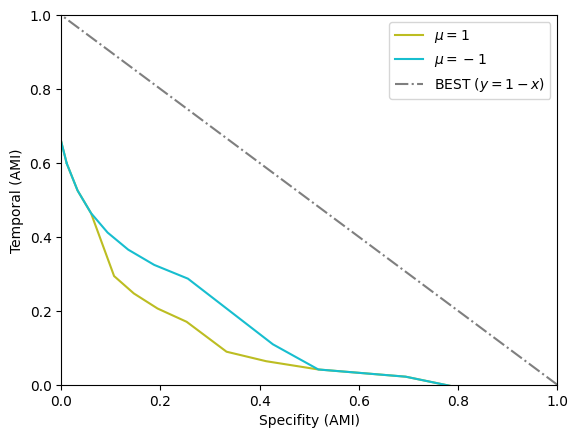

In [85]:
plt.plot(SPECs_mu1, TEMPs_mu1, 'C8')
plt.plot(SPECs_mu_1, TEMPs_mu_1, 'C9')
plt.plot(SPECs, 1 - np.array(SPECs), 'tab:gray', linestyle='-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Specifity (AMI)")
plt.ylabel("Temporal (AMI)")
plt.legend(["$\mu=1$", "$\mu=-1$", "BEST ($y=1-x$)"])
plt.savefig(f"AMI_AUC_muVS.pdf", bbox_inches='tight')

# Duality ?

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

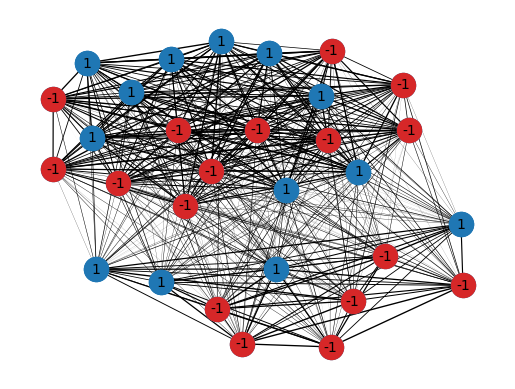

In [ ]:
x = fair_clustering_EVD(A, s, mu=0.235, lambda_=1)
show_weighted_graph_with_colors(A,              # temporal
                                labels=x,       # prediction
                                colors=colors)  # specifity